In [1]:
import json
import pickle
import numpy as np
from matplotlib import pyplot as plt
from os.path import exists

In [15]:
plt.rcParams.update({'font.size': 14})

In [4]:
attention_name = 'data/attention/python_0_1000_attn.pkl' if exists("data/attention/python_0_1000_attn.pkl") else 'data/CuBERT_tokenized/python_0_1000_attn.pkl'
with open(attention_name, 'rb') as f:
    dev_data = pickle.load(f)
with open("../../CodeSyntax/CodeSyntax_python.json", 'r') as f:
    dataset = json.load(f)

In [3]:
attention_name = 'data/attention/java_0_1000_attn.pkl' if exists("data/attention/java_0_1000_attn.pkl") else 'data/CuBERT_tokenized/java_0_1000_attn.pkl'
with open(attention_name, 'rb') as f:
    dev_data = pickle.load(f)
with open("../../CodeSyntax/CodeSyntax_java_with_new_lines.json", 'r') as f:
    dataset = json.load(f)

In [10]:
# Function for visualizing attention 
# This function is adopted from https://github.com/clarkkev/attention-analysis
def plot_attn_word(title, example, layer, head, color_words, width=1, 
              word_height=1, pad=0.1,  plot_range=None, save=False, count=None, 
                   skip=None, xoffset = 0, yoffset=0, new_fig=True):
    """Plot BERT's attention for a particular head/example."""

    attn = example["attns"][layer][head]
    attn_max = attn.sum(axis=-1, keepdims=True)
    attn_max[attn_max == 0] = 1
    attn /= attn_max
    # [CLS] and [SEP] are already removed fron word-level attention

    if "python_tokens" in example:
        words = example["python_tokens"]
    else:
        words = example["java_tokens"]
    if plot_range != None:
        start, end = plot_range[0], plot_range[1]
        if skip != None:
            print(attn[start:skip[0], start:skip[0]].shape)
            words = words[start:skip[0]] + ["..."] + words[skip[1]:end]
            attn = attn[start:end, start:end]
            np.delete(attn, np.s_[skip[0]-start:skip[1]-start], axis=0)
            np.delete(attn, np.s_[skip[0]-start:skip[1]-start], axis=1)
            col = np.zeros((attn.shape[0],1))
            attn = np.hstack((attn[:,:skip[0]-start], col, attn[:,skip[0]-start:]))
            row = np.zeros((1, attn.shape[1]))
            attn = np.vstack((attn[:skip[0]-start,:], row, attn[skip[0]-start:,:]))
        else:
            attn = attn[start:end, start:end]
            words = words[start:end]
        
        
        
    n_words = len(words)
    remaining_count = n_words if count == None else count
    if new_fig:
        plt.figure(figsize=(width, n_words*0.3))
    print(n_words, "tokens")
    for position, word in enumerate(words):
      for x, from_word in [(xoffset, True), (xoffset + width, False)]:
        color = "k"
        if word in color_words and remaining_count>0 and  from_word==True:
          color = "#cc0000"
          remaining_count -= 1
        # truncate string if it's too long
        word = (word[:25] + '...') if len(word) > 25 else word
        plt.text(x, yoffset - (position * word_height), repr(word),
                 ha="right" if from_word else "left", va="center",
                 color=color)

    remaining_count = n_words if count == None else count
    for i in range(n_words):
        color = "b"
        if words[i] in color_words and remaining_count>0:
            color = "r"
            remaining_count -= 1
        for j in range(n_words):
            plt.plot([xoffset + pad, xoffset + width - pad],
                 [yoffset - word_height * i, yoffset - word_height * j],
                 color=color, linewidth=1, alpha=attn[i, j])
    plt.axis("off")
#     plt.title(title)
    if save:
        plt.savefig("../../data/figures/"+title+".pdf", bbox_inches='tight')
#         plt.savefig("../../data/figures/"+title+".png", bbox_inches='tight')
    if new_fig:
        plt.show()

In [6]:
def get_correct_incorrect_prediction(attn_data, dataset, reln, attn_layer, attn_head, metric="first",plot=None, skip_newlines=False):
    correct = []
    incorrect = []
    for index, example in enumerate(attn_data):
        i = example['id']
        tokens = example["python_tokens"] if "python_tokens" in example else example["java_tokens"]
        if reln in dataset[i]["relns"]:
            for head_idx, dep_range_start_idx, dep_range_end_idx in dataset[i]["relns"][reln]:
                attn = example["attns"][attn_layer][attn_head][head_idx]
                attn[head_idx] = 0
                prediction = np.argmax(attn)
                if skip_newlines and tokens[prediction]=='\n':
                    sorted_idx = attn.argsort()[::-1]
                    assert prediction == sorted_idx[0]
                    i = 1
                    while tokens[sorted_idx[i]]=='\n':
                        i += 1
                    prediction = sorted_idx[i]
                
                if ((metric == "first" and prediction == dep_range_start_idx) or
                            (metric == "last" and prediction == dep_range_end_idx) or
                            (metric == "any" and prediction >= dep_range_start_idx and prediction <= dep_range_end_idx)):
                    correct.append((index,head_idx,tokens[head_idx],prediction, tokens[prediction]))
                else:
                    incorrect.append((index,head_idx,tokens[head_idx],prediction, 
                                      tokens[prediction], dep_range_start_idx, 
                                      tokens[dep_range_start_idx]))
    print(correct)
    print(incorrect)
    if plot == "incorrect":
        for index, head_idx, head_token, prediction, tp, dep_range_start_idx,  th in incorrect:
            print(index, head_idx, head_token, prediction, tp, dep_range_start_idx,  th)
            plot_attn_word("incorrect", dev_data[index], attn_layer, attn_head, [head_token], 
                           plot_range=(head_idx, max(prediction, dep_range_start_idx)+1), save=False)
                        
    return correct, incorrect

17 tokens


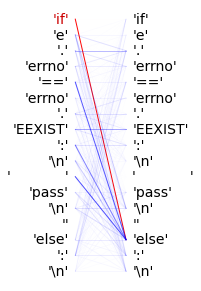

In [16]:
plot_attn_word("Head 17-2 if else", dev_data[74], 16, 1, ["if"], plot_range=(29,46), save=True)

[(10, 139, 'if', 164, 'else'), (11, 34, 'if', 64, 'elif'), (11, 64, 'elif', 113, 'elif'), (11, 130, 'if', 153, 'elif'), (12, 25, 'if', 47, 'elif'), (12, 47, 'elif', 69, 'else'), (20, 42, 'elif', 54, 'elif'), (20, 54, 'elif', 110, 'elif'), (20, 110, 'elif', 122, 'elif'), (26, 100, 'if', 124, 'elif'), (28, 54, 'if', 175, 'else'), (31, 61, 'if', 81, 'else'), (31, 107, 'if', 126, 'else'), (32, 14, 'if', 65, 'else'), (32, 42, 'if', 56, 'else'), (37, 95, 'if', 110, 'elif'), (37, 151, 'if', 171, 'else'), (56, 12, 'if', 39, 'else'), (57, 16, 'if', 43, 'else'), (57, 69, 'if', 82, 'else'), (63, 56, 'elif', 114, 'else'), (65, 12, 'if', 51, 'else'), (74, 29, 'if', 43, 'else'), (75, 79, 'if', 106, 'else'), (78, 72, 'if', 99, 'else'), (82, 35, 'if', 103, 'else'), (82, 117, 'if', 143, 'else'), (82, 153, 'if', 179, 'else'), (83, 36, 'if', 58, 'else'), (87, 53, 'if', 68, 'else'), (93, 52, 'if', 88, 'else'), (96, 84, 'if', 111, 'else'), (102, 16, 'if', 40, 'else'), (103, 12, 'if', 35, 'else'), (108, 27,

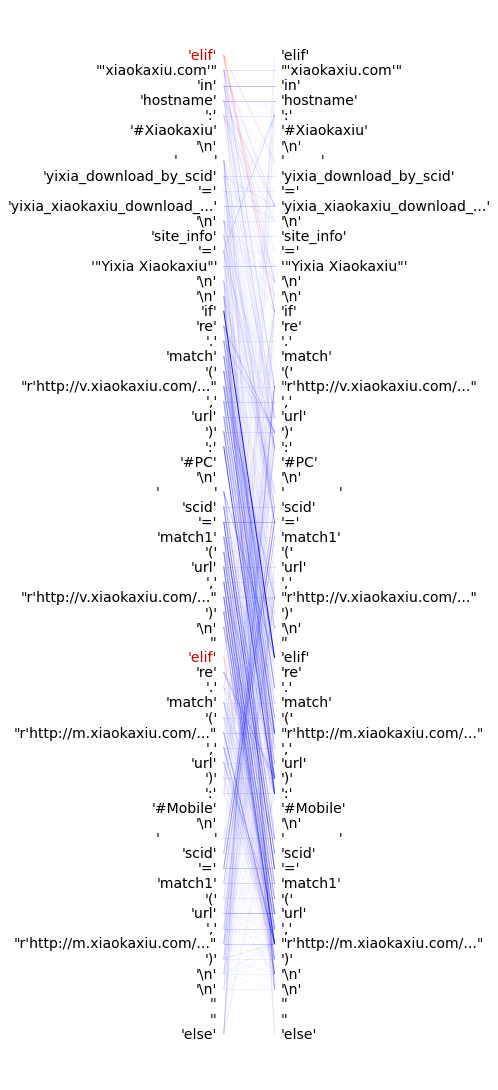

20 30 if 54 elif 42 elif
25 tokens


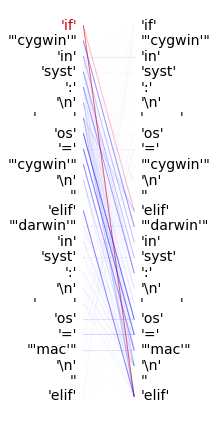

63 39 if 114 else 56 elif
76 tokens


KeyboardInterrupt: 

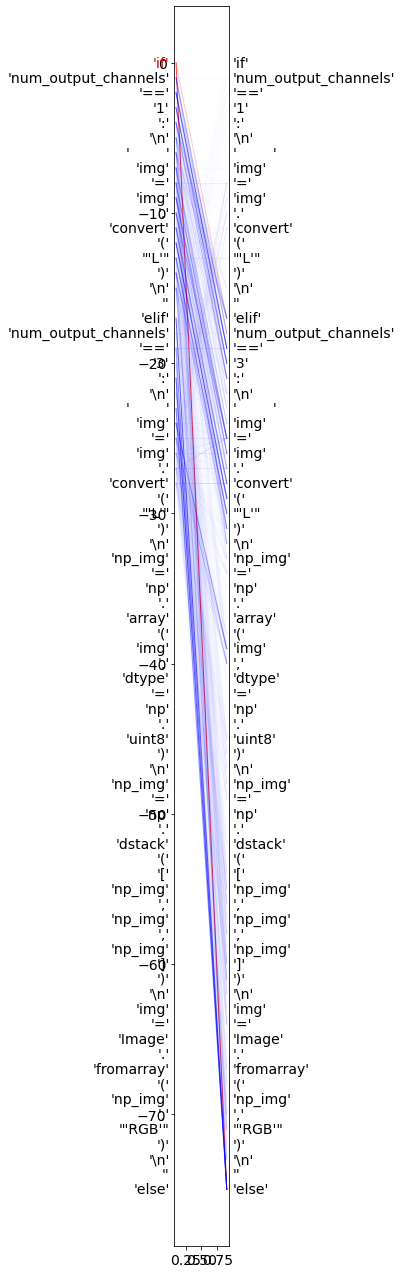

In [19]:
# error cases If:if->else
correct, incorrect = get_correct_incorrect_prediction(dev_data, dataset, 'If:if->else', 16, 1,  "any", plot="incorrect")

In [12]:
print(dev_data[611]["python_tokens"][11:59])

['if', '(', 'len', '(', 'self', '.', 'stack', ')', '>', '0', ')', ':', '\n', '            ', 'while', '(', 'len', '(', 'self', '.', 'stack', ')', '>', '0', ')', ':', '\n', '                ', 'await', 'self', '.', 'end_active_dialog', '(', 'DialogReason', '.', 'CancelCalled', ')', '\n', '', 'return', 'DialogTurnResult', '(', 'DialogTurnStatus', '.', 'Cancelled', ')', '\n', '']


In [13]:
print(" ".join(dev_data[611]["python_tokens"][11:70]))

if ( len ( self . stack ) > 0 ) : 
              while ( len ( self . stack ) > 0 ) : 
                  await self . end_active_dialog ( DialogReason . CancelCalled ) 
  return DialogTurnResult ( DialogTurnStatus . Cancelled ) 
  else : 
              return DialogTurnResult ( DialogTurnStatus . Empty )


(15, 15)
18 tokens


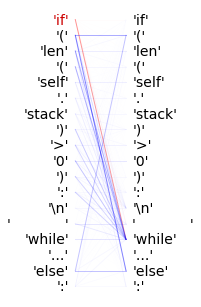

In [17]:
plot_attn_word("error case Head 17-2 if else", dev_data[611], 16, 1, ["if"], plot_range=(11,61), skip=(26,59),save=True)

17 tokens
(15, 15)
18 tokens


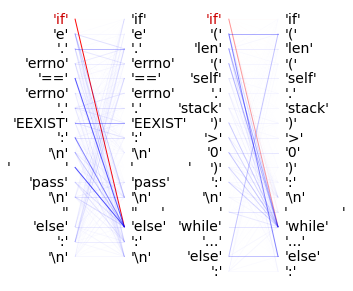

In [44]:
# If:if->else
plt.figure(figsize=(4, (46-29)*0.3))
title="Python Head 17-2 if else"
plot_attn_word("Head 17-2 if else", dev_data[74], 16, 1, ["if"], plot_range=(29,46), new_fig=False)
plot_attn_word("error case Head 17-2 if else", dev_data[611], 16, 1, ["if"], 
               plot_range=(11,61), skip=(26,59), xoffset=2.5, new_fig=False)
plt.savefig("data/figures/"+title+".pdf", bbox_inches='tight')
plt.savefig("data/figures/"+title+".png", bbox_inches='tight')

13 tokens


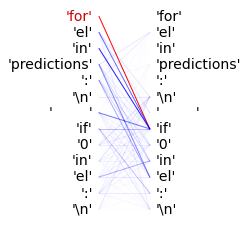

In [48]:
plot_attn_word("Head 18-4 for body", dev_data[212], 17, 3, ["for"],  plot_range=(80,93), save=True)  

13 tokens


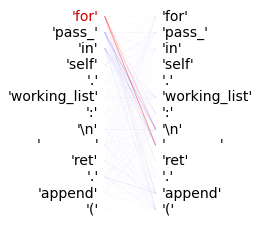

In [47]:
plot_attn_word("Error Case Head 18-4 for body", dev_data[639], 17, 3, ["for"], plot_range=(15,28), save=True)

13 tokens
13 tokens


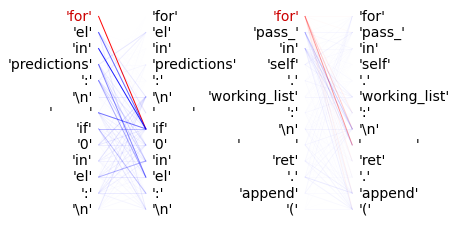

In [55]:
# If:if->else
plt.figure(figsize=(5, 13*0.3))
title="Python Head 18-4 for body"
plot_attn_word("Head 18-4 for body", dev_data[212], 17, 3, ["for"],  plot_range=(80,93), new_fig=False)  
plot_attn_word("Error Casey", dev_data[639], 17, 3, ["for"], plot_range=(15,28), xoffset=3.5, new_fig=False)
plt.savefig("data/figures/"+title+".pdf", bbox_inches='tight')
plt.savefig("data/figures/"+title+".png", bbox_inches='tight')

13 python tokens


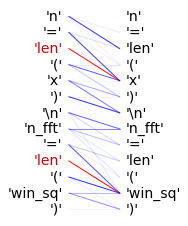

In [47]:
plot_attn_word("Head 15-11 Call func args", dev_data[432], 14, 10, ["len"], plot_range=(18,31), save=True)

8 python tokens


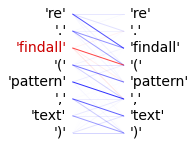

In [85]:
plot_attn_word("error case Head 15-11 Call func args", dev_data[33], 14, 10, ["findall"], plot_range=(27,35), save=True)

13 tokens
8 tokens


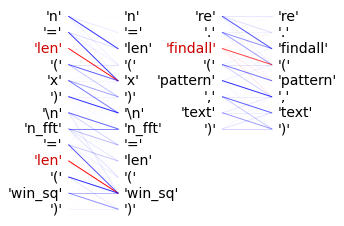

In [59]:
# If:if->else
plt.figure(figsize=(4, 13*0.3))
title="Python Head 15-11 Call func args"
plot_attn_word("Head 15-11 Call func args", dev_data[432], 14, 10, ["len"], plot_range=(18,31), new_fig=False)
plot_attn_word("error case", dev_data[33], 14, 10, ["findall"], plot_range=(27,35), xoffset=2.5, new_fig=False)
plt.savefig("data/figures/"+title+".pdf", bbox_inches='tight')
plt.savefig("data/figures/"+title+".png", bbox_inches='tight')

9 python tokens


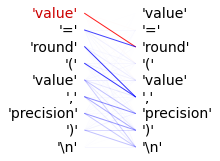

In [48]:
plot_attn_word("Head 15-10 Assign target value", dev_data[158], 14, 9, ["value"], count=1, plot_range=(43,52), save=True)

In [ ]:
# error cases Assign:target->value
correct, incorrect = get_correct_incorrect_prediction(dev_data, dataset, 'Assign:target->value', 14, 9, "any", plot="incorrect")

8 tokens


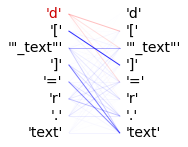

In [74]:
plot_attn_word("error case Head 15-10 Assign target value", dev_data[5], 14, 9, ["d"], plot_range=(50,58), save=True)

9 tokens
8 tokens


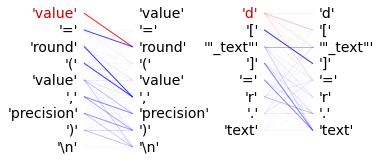

In [62]:
# If:if->else
plt.figure(figsize=(4.5, 9*0.3))
title="Python Head 15-10 Assign target value"
plot_attn_word("Head 15-10 Assign target value", dev_data[158], 14, 9, ["value"], count=1, plot_range=(43,52), new_fig=False)
plot_attn_word("error case", dev_data[5], 14, 9, ["d"], plot_range=(50,58), xoffset=3, new_fig=False)
plt.savefig("data/figures/"+title+".pdf", bbox_inches='tight')
plt.savefig("data/figures/"+title+".png", bbox_inches='tight')

In [ ]:
# error cases If:body->orelse
correct, incorrect = get_correct_incorrect_prediction(dev_data, dataset, 'If:body->orelse', 6, 5,  "any", plot="incorrect")

In [ ]:
# error cases If:if->body
correct, incorrect = get_correct_incorrect_prediction(dev_data, dataset, 'If:if->body', 17, 3,  "any", plot="incorrect")

In [ ]:
# error cases Assign:target->value
correct, incorrect = get_correct_incorrect_prediction(dev_data, dataset, 'Assign:target->value', 14, 9,  "any", plot="incorrect")

In [ ]:
# error cases While:test->body
correct, incorrect = get_correct_incorrect_prediction(dev_data, dataset, 'While:test->body', 17, 3,  "any", plot="incorrect")

In [ ]:
# error cases Call:func->args
correct, incorrect = get_correct_incorrect_prediction(dev_data, dataset, 'Call:func->args', 14, 10,  "any", plot="incorrect")

In [ ]:
# error cases For:for->body
correct, incorrect = get_correct_incorrect_prediction(dev_data, dataset, 'For:for->body', 17, 3,  "any", plot="incorrect")

# java

979
18 tokens


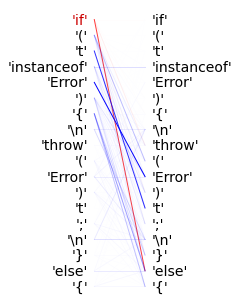

In [19]:
plot_attn_word("Java Head 9-10 if else", dev_data[979], 8, 9, ["if"], plot_range=(27,45), save=True)

In [ ]:
# error cases If:if->else
correct, incorrect = get_correct_incorrect_prediction(dev_data, dataset, 'If:if->else', 8, 9, "any", plot="incorrect")

In [13]:
print("".join(dev_data[478]["java_tokens"][23:62]))

if(error.addThrowable(ex)){
if(wip.getAndIncrement()==0){
subscriber.onError(error.terminate());
}
}else


(12, 12)
16 tokens


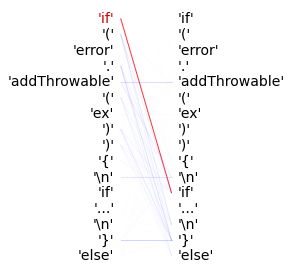

In [14]:
plot_attn_word("error case Java Head 9-10 if else", dev_data[478], 8, 9, ["if"], count = 1, plot_range=(23,62), skip =(35,59), save=True)

18 tokens
(12, 12)
16 tokens


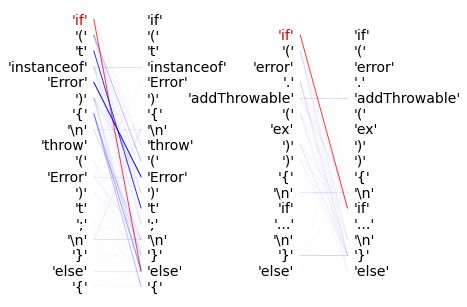

In [12]:
# If:if->else
plt.figure(figsize=(5, 18*0.3))
title="Java Head 9-10 if else"
plot_attn_word("Java Head 9-10 if else", dev_data[979], 8, 9, ["if"], plot_range=(27,45), new_fig=False)
plot_attn_word("error case Java Head 9-10 if else", dev_data[478], 8, 9, ["if"], count = 1, 
               plot_range=(23,62), skip =(35,59), xoffset=3.5, yoffset=-1, new_fig=False)
plt.savefig("data/figures/"+title+".pdf", bbox_inches='tight')
plt.savefig("data/figures/"+title+".png", bbox_inches='tight')

14 tokens


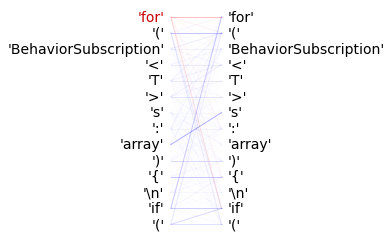

In [13]:
plot_attn_word("Java Head 16-5 for body", dev_data[954], 15, 4, ["for"], plot_range=(49,63), save=True)

In [ ]:
# error cases For:for->body
correct, incorrect = get_correct_incorrect_prediction(dev_data, dataset, 'For:for->body', 15, 4, "first", plot="incorrect")

In [40]:
print("".join(dev_data[532]["java_tokens"][17:25]))

for(;;){
CacheSubscription


8 tokens


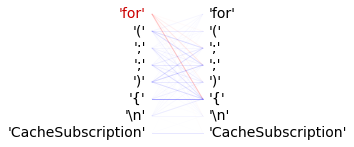

In [42]:
plot_attn_word("error case Java Head 16-5 for body", dev_data[532], 15, 4, ["for"], plot_range=(17,25), save=True)

14 tokens
8 tokens


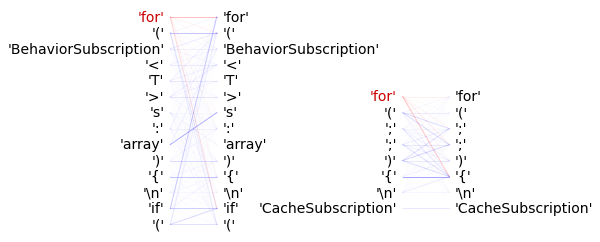

In [19]:
# If:if->else
plt.figure(figsize=(5.5, 14*0.3))
title="Java Head 16-5 for body"
plot_attn_word("Java Head 16-5 for body", dev_data[954], 15, 4, ["for"], plot_range=(49,63), new_fig=False)
plot_attn_word("error case Java Head 16-5 for body", dev_data[532], 15, 4, ["for"], plot_range=(17,25), xoffset=4, yoffset=-5, new_fig=False)
plt.savefig("data/figures/"+title+".pdf", bbox_inches='tight')
plt.savefig("data/figures/"+title+".png", bbox_inches='tight')

7 tokens


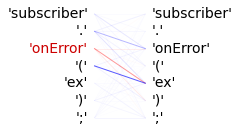

In [20]:
plot_attn_word("Java Head 19-9 func args", dev_data[479], 18, 8, ["onError"], plot_range=(49,56), save=True)

In [ ]:
# error cases Call:func->args
correct, incorrect = get_correct_incorrect_prediction(dev_data, dataset, 'Call:func->args', 18, 8, "any", plot="incorrect")

4 tokens


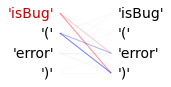

In [54]:
plot_attn_word("error case Java Head 19-9 func args", dev_data[347], 18, 8, ["isBug"], plot_range=(48,52), save=True)

7 tokens
4 tokens


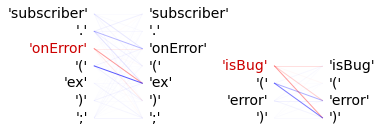

In [26]:
# If:if->else
plt.figure(figsize=(4.5, 7*0.3))
title="Java Head 19-9 func args"
plot_attn_word("Java Head 19-9 func args", dev_data[479], 18, 8, ["onError"], plot_range=(49,56), new_fig=False)
plot_attn_word("error case Java Head 19-9 func args", dev_data[347], 18, 8, ["isBug"], plot_range=(48,52), xoffset=3, yoffset=-3, new_fig=False)
plt.savefig("data/figures/"+title+".pdf", bbox_inches='tight')
plt.savefig("data/figures/"+title+".png", bbox_inches='tight')

7 tokens


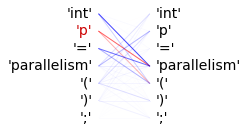

In [27]:
plot_attn_word("Java Head 20-10 Assign target value", dev_data[284], 19, 9, ["p"], plot_range=(17, 24),  save=True)

In [ ]:
# error cases Assign:target->value
correct, incorrect = get_correct_incorrect_prediction(dev_data, dataset, 'Assign:target->value', 19, 9, "any", plot="incorrect")

6 tokens


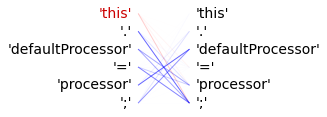

In [52]:
plot_attn_word("error case Java Head 20-10 Assign target value", dev_data[981], 19, 9, ["this"], plot_range=(22, 28),  save=True)

7 tokens
6 tokens


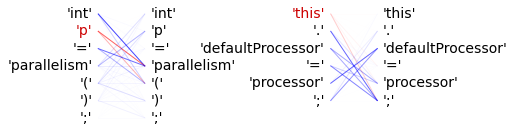

In [31]:
# If:if->else
plt.figure(figsize=(5.5, 7*0.3))
title="Java Head 20-10 Assign target value"
plot_attn_word("Java Head 20-10 Assign target value", dev_data[284], 19, 9, ["p"], plot_range=(17, 24),  new_fig=False)
plot_attn_word("error case Java Head 20-10 Assign target value", dev_data[981], 19, 9, ["this"], plot_range=(22, 28),  xoffset=4, yoffset=0, new_fig=False)
plt.savefig("data/figures/"+title+".pdf", bbox_inches='tight')
plt.savefig("data/figures/"+title+".png", bbox_inches='tight')

In [ ]:
# error cases If:body->orelse
correct, incorrect = get_correct_incorrect_prediction(dev_data, dataset, 'If:body->orelse', 8, 9, "any", plot="incorrect")

In [ ]:
# error cases If:if->body
correct, incorrect = get_correct_incorrect_prediction(dev_data, dataset, 'If:if->body', 18, 15, "any", plot="incorrect")

In [ ]:
# error cases For:for->body
correct, incorrect = get_correct_incorrect_prediction(dev_data, dataset, 'For:for->body', 15, 4, "any", plot="incorrect")

In [ ]:
# error cases Assign:target->value
correct, incorrect = get_correct_incorrect_prediction(dev_data, dataset, 'Assign:target->value', 19, 9, "any", plot="incorrect", skip_newlines=True)

In [ ]:
# error cases While:test->body
correct, incorrect = get_correct_incorrect_prediction(dev_data, dataset, 'While:test->body', 6, 14, "any", plot="incorrect")

In [ ]:
# error cases Call:func->args
correct, incorrect = get_correct_incorrect_prediction(dev_data, dataset, 'Call:func->args', 18, 8, "any", plot="incorrect")